In [ ]:
!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
!unzip DIV2K_train_HR.zip # This is our dataset link. I will include this command in the description

--2024-02-03 15:29:46--  http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip [following]
--2024-02-03 15:29:46--  https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3530603713 (3.3G) [application/zip]
Saving to: ‘DIV2K_train_HR.zip’

DIV2K_train_HR.zip  100%[===================>]   3.29G  19.0MB/s    in 3m 4s   

2024-02-03 15:32:51 (18.3 MB/s) - ‘DIV2K_train_HR.zip’ saved [3530603713/3530603713]

Archive:  DIV2K_train_HR.zip
   creating: DIV2K_train_HR/
  inflating: DIV2K_train_HR/0103.png  
  inflating: DIV2K_

In [3]:
# Do set your runtime to GPU. You will need it
import torch
import math
from os import listdir
import numpy as np
from torch.autograd import Variable

In [4]:
from torchvision.transforms import Compose, RandomCrop, ToTensor, ToPILImage, CenterCrop, Resize

In [5]:
from torch.utils.data import DataLoader, Dataset

In [6]:
from PIL import Image

In [7]:
from os.path import join

In [8]:
torch.autograd.set_detect_anomaly(True)

In [9]:
UPSCALE_FACTOR = 4
CROP_SIZE = 88

In [10]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

In [11]:
# Now, I will load in some code for the dataset and dataloaders.
# Link to this notebook will be in the description, so you can get it from there
def is_image_file(filename):
    return any(filename.endswith(extension) for extension in ['.png', '.jpg', '.jpeg', '.PNG', '.JPG', '.JPEG'])


def calculate_valid_crop_size(crop_size, upscale_factor):
    return crop_size - (crop_size % upscale_factor)


def train_hr_transform(crop_size):
    return Compose([
        RandomCrop(crop_size),
        ToTensor(),
    ])


def train_lr_transform(crop_size, upscale_factor):
    return Compose([
        ToPILImage(),
        Resize(crop_size // upscale_factor, interpolation=Image.BICUBIC),
        ToTensor()
    ])


def display_transform():
    return Compose([
        ToPILImage(),
        Resize(400),
        CenterCrop(400),
        ToTensor()
    ])


class TrainDatasetFromFolder(Dataset):
    def __init__(self, dataset_dir, crop_size, upscale_factor):
        super(TrainDatasetFromFolder, self).__init__()
        self.image_filenames = [join(dataset_dir, x) for x in listdir(dataset_dir) if is_image_file(x)]
        crop_size = calculate_valid_crop_size(crop_size, upscale_factor)
        self.hr_transform = train_hr_transform(crop_size)
        self.lr_transform = train_lr_transform(crop_size, upscale_factor)

    def __getitem__(self, index):
        hr_image = self.hr_transform(Image.open(self.image_filenames[index]))
        lr_image = self.lr_transform(hr_image)
        return lr_image, hr_image

    def __len__(self):
        return len(self.image_filenames)

In [ ]:
# That was the dataset code.
# Now lets load the train set
# Forgot to import join from os.path

In [ ]:
train_set = TrainDatasetFromFolder("DIV2K_train_HR", crop_size=CROP_SIZE,
                                   upscale_factor=UPSCALE_FACTOR)
trainloader = DataLoader(train_set, batch_size=64, num_workers=4, shuffle=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [12]:
from torch import nn, optim

In [13]:
# Now we will start implementing the model. We will start in this vid, and co,plee
# in the next video
class ResidualBlock(nn.Module):
  def __init__(self, channels):
    super(ResidualBlock, self).__init__()
    self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
    self.bn1 = nn.BatchNorm2d(channels)
    self.prelu = nn.PReLU()
    self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
    self.bn2 = nn.BatchNorm2d(channels)
  def forward(self, x):
    residual = self.conv1(x)
    residual = self.bn1(residual)
    residual = self.prelu(residual)
    residual = self.conv2(residual)
    residual = self.bn2(residual)
    return x + residual

# We just implemented a pretty standard residual block here

In [14]:
class UpsampleBlock(nn.Module):
  def __init__(self, in_channels, up_scale):
    super(UpsampleBlock, self).__init__()
    self.conv = nn.Conv2d(in_channels, in_channels * up_scale ** 2,
                          kernel_size=3, padding=1)
    self.pixel_shuffle = nn.PixelShuffle(up_scale)
    self.prelu = nn.PReLU()
  def forward(self, x):
    x = self.conv(x)
    x = self.pixel_shuffle(x)
    x = self.prelu(x)
    return x

In [15]:
class Generator(nn.Module):
  def __init__(self, scale_factor):
    super(Generator, self).__init__()
    upsample_block_num = int(math.log(scale_factor, 2))

    self.block1 = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=9, padding=4),
        nn.PReLU()
    )

    self.block2 = ResidualBlock(64)
    self.block3 = ResidualBlock(64)
    self.block4 = ResidualBlock(64)
    self.block5 = ResidualBlock(64)
    self.block6 = ResidualBlock(64)
    self.block7 = nn.Sequential(
        nn.Conv2d(64, 64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64)
    )
    block8 = [UpsampleBlock(64, 2) for _ in range(upsample_block_num)]
    block8.append(nn.Conv2d(64, 3, kernel_size=9, padding=4))
    self.block8 = nn.Sequential(*block8)
  def forward(self, x):
    block1 = self.block1(x)
    block2 = self.block2(block1)
    block3 = self.block3(block2)
    block4 = self.block4(block3)
    block5 = self.block5(block4)
    block6 = self.block6(block5)
    block7 = self.block7(block6)
    block8 = self.block8(block1 + block7)
    return (torch.tanh(block8) + 1) / 2

In [16]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.net = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=3, padding=1),
        nn.LeakyReLU(0.2),

        nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2),

        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2),

        nn.Conv2d(128, 256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2),

        nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2),

        nn.Conv2d(256, 512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2),

        nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2),

        nn.AdaptiveAvgPool2d(1),
        nn.Conv2d(512, 1024, kernel_size=1),
        nn.LeakyReLU(0.2),
        nn.Conv2d(1024, 1, kernel_size=1)
    )
  def forward(self, x):
    batch_size=x.size()[0]
    return torch.sigmoid(self.net(x).view(batch_size))

In [17]:
from torchvision.models.vgg import vgg16

In [18]:
# Now we got to make the Generator Loss
class TVLoss(nn.Module):
  def __init__(self, tv_loss_weight=1):
    super(TVLoss, self).__init__()
    self.tv_loss_weight=tv_loss_weight
  def forward(self, x):
    batch_size=x.size()[0]
    h_x = x.size()[2]
    w_x = x.size()[3]

    count_h = self.tensor_size(x[:, :, 1:, :])
    count_w = self.tensor_size(x[:, :, :, 1:])

    h_tv = torch.pow(x[:, :, 1:, :] - x[:, :, :h_x - 1, :], 2).sum()
    w_tv = torch.pow(x[:, :, :, 1:] - x[:, :, :, :w_x - 1], 2).sum()
    return self.tv_loss_weight * 2 * (h_tv / count_h + w_tv / count_w) / batch_size

  # Forgot to implement an important method
  @staticmethod # Must add this
  def tensor_size(t):
    return t.size()[1] * t.size()[2] * t.size()[3]

In [19]:
class GeneratorLoss(nn.Module):
  def __init__(self):
    super(GeneratorLoss, self).__init__()
    vgg = vgg16(pretrained=True)
    loss_network = nn.Sequential(*list(vgg.features)[:31]).eval()
    for param in loss_network.parameters():
      param.requires_grad = False
    self.loss_network = loss_network
    self.mse_loss = nn.MSELoss()
    self.tv_loss = TVLoss()
  def forward(self, out_labels, out_images, target_images):
    adversial_loss = torch.mean(1 - out_labels)
    perception_loss = self.mse_loss(out_images, target_images)
    image_loss = self.mse_loss(out_images, target_images)
    tv_loss = self.tv_loss(out_images)
    return image_loss + 0.001 * adversial_loss + 0.006 * perception_loss + 2e-8 * tv_loss


In [20]:
device  = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Standard device selectoin
device

device(type='cuda')

In [21]:
netG = Generator(UPSCALE_FACTOR)
netD = Discriminator()

In [22]:
generator_criterion = GeneratorLoss()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:08<00:00, 68.6MB/s]


In [23]:
generator_criterion = generator_criterion.to(device)
netG = netG.to(device)
netD = netD.to(device)

In [24]:
optimizerG = optim.Adam(netG.parameters(), lr=0.0002)
optimizerD = optim.Adam(netD.parameters(), lr=0.0002)

In [25]:
results = {
    "d_loss":[],
    "g_loss":[],
    "d_score": [],
    "g_score": []
}

In [26]:
## Now for training code
from tqdm import tqdm
import os

In [ ]:
N_EPOCHS = 150 # 150 is good enough for our model. gives decent enough results

In [ ]:
for epoch in range(1, N_EPOCHS + 1):
  train_bar = tqdm(trainloader)
  running_results = {'batch_sizes':0, 'd_loss':0,
                     "g_loss":0, "d_score":0, "g_score":0}

  netG.train()
  netD.train()
  for data, target in train_bar:
    g_update_first = True
    batch_size = data.size(0)
    running_results['batch_sizes'] += batch_size

    real_img = Variable(target)
    real_img = real_img.to(device)
    z = Variable(data)
    z = z.to(device)

    ## Update Discriminator ##
    fake_img = netG(z)
    netD.zero_grad()
    real_out = netD(real_img).mean()
    fake_out = netD(fake_img).mean()
    d_loss = 1 - real_out + fake_out
    d_loss.backward(retain_graph = True)
    optimizerD.step()

    ## Now update Generator
    fake_img = netG(z)
    fake_out = netD(fake_img).mean()
    netG.zero_grad()
    g_loss = generator_criterion(fake_out, fake_img, real_img)
    g_loss.backward()

    fake_img = netG(z)
    fake_out = netD(fake_img).mean()

    optimizerG.step()

    running_results['g_loss'] += g_loss.item() * batch_size
    running_results['d_loss'] += d_loss.item() * batch_size
    running_results['d_score'] += real_out.item() * batch_size
    running_results['g_score'] += real_out.item() * batch_size

    ## Updating the progress bar
    train_bar.set_description(desc="[%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f" % (
        epoch, N_EPOCHS, running_results['d_loss'] / running_results['batch_sizes'],
        running_results['g_loss'] / running_results['batch_sizes'],
        running_results['d_score'] / running_results['batch_sizes'],
        running_results['g_score'] / running_results['batch_sizes']
    ))
  netG.eval()

[1/150] Loss_D: 0.7982 Loss_G: 0.0427 D(x): 0.5707 D(G(z)): 0.5707: 100%|██████████| 13/13 [01:01<00:00,  4.71s/it]
[2/150] Loss_D: 0.6226 Loss_G: 0.0170 D(x): 0.6732 D(G(z)): 0.6732: 100%|██████████| 13/13 [01:01<00:00,  4.71s/it]
[3/150] Loss_D: 0.2918 Loss_G: 0.0138 D(x): 0.8359 D(G(z)): 0.8359: 100%|██████████| 13/13 [01:00<00:00,  4.67s/it]
[4/150] Loss_D: 0.2918 Loss_G: 0.0129 D(x): 0.8395 D(G(z)): 0.8395: 100%|██████████| 13/13 [01:00<00:00,  4.63s/it]
[5/150] Loss_D: 0.9838 Loss_G: 0.0108 D(x): 0.9236 D(G(z)): 0.9236: 100%|██████████| 13/13 [01:01<00:00,  4.70s/it]
[6/150] Loss_D: 0.9765 Loss_G: 0.0097 D(x): 0.8521 D(G(z)): 0.8521: 100%|██████████| 13/13 [01:00<00:00,  4.67s/it]
[7/150] Loss_D: 0.9519 Loss_G: 0.0096 D(x): 0.7436 D(G(z)): 0.7436: 100%|██████████| 13/13 [00:59<00:00,  4.61s/it]
[8/150] Loss_D: 0.8191 Loss_G: 0.0091 D(x): 0.7535 D(G(z)): 0.7535: 100%|██████████| 13/13 [01:00<00:00,  4.67s/it]
[9/150] Loss_D: 0.7943 Loss_G: 0.0090 D(x): 0.6807 D(G(z)): 0.6807: 100%

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# We will just make sure that this model trains 5 epochs successfuly
# This will take around 2 hours to train, please monitor colab
# To make sure that it does not time out
# There might be few errors, mostly due to typos
# The progress bar acts slightly weird
# But you see the model is now training


In [ ]:


# Save model to Google Drivee/My Drive/generator_weights.pth')
torch.save(netG.state_dict(), '/content/drive/My Drive/generator_weights.pth')


In [27]:
# Load the trained model
netG = Generator(UPSCALE_FACTOR)
netG.load_state_dict(torch.load('/content/drive/My Drive/generator_weights.pth'))  # Provide the path to your saved model file
netG = netG.to(device)  # Move the model to the GPU

# Now you can proceed with testing
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from PIL import Image
import os

# Define Test Dataset Class
class TestDatasetFromFolder(Dataset):
    def __init__(self, dataset_dir, upscale_factor):
        self.image_filenames = [os.path.join(dataset_dir, x) for x in os.listdir(dataset_dir)]
        self.upscale_factor = upscale_factor
        self.transform = ToTensor()

    def __getitem__(self, index):
        # Load image
        img = Image.open(self.image_filenames[index])
        # Apply any preprocessing transforms
        img = self.transform(img)
        return img

    def __len__(self):
        return len(self.image_filenames)

# Set directory path for test data
test_data_dir = "/content/drive/My Drive/test"

# Set upscale factor
upscale_factor = 4  # Adjust as needed

# Instantiate Test Dataset
test_set = TestDatasetFromFolder(test_data_dir, upscale_factor=upscale_factor)

# Set batch size and number of workers for DataLoader
batch_size = 1  # Adjust as needed
num_workers = 0  # Adjust as needed

# Create DataLoader for Testing
testloader = DataLoader(test_set, batch_size=batch_size, num_workers=num_workers)

# Iterate Over Test DataLoader
for data in testloader:
    # Perform evaluation using the loaded test data
    # Pass each batch of test images through your trained model for evaluation
    # Replace the comment below with your evaluation code
    # For example, you can print the shape of each batch to ensure it is loaded correctly
    print("Batch shape:", data.shape)


Batch shape: torch.Size([1, 3, 500, 500])


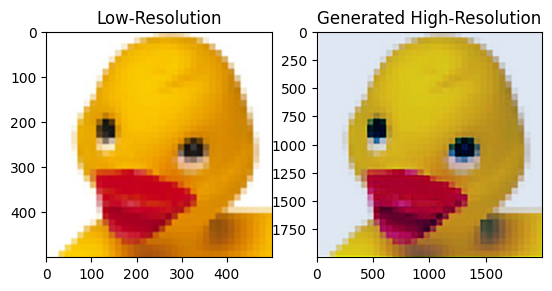

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Iterate over test data and perform evaluation
for data_idx, data in enumerate(testloader):
    # Perform evaluation using the loaded test data
    # Pass each batch of test images through your trained model for evaluation
    # Replace the comment below with your evaluation code
    # For example:
    # predicted_hr_images = netG(data.to(device))

    # Convert generated HR images to numpy arrays
    generated_hr_images = netG(data.to(device)).detach().cpu().numpy()

    # Iterate over batch and visualize results
    for i in range(batch_size):
        # Convert tensors to numpy arrays for visualization
        lr_image = data[i].numpy().transpose((1, 2, 0))  # Convert from CxHxW to HxWxC
        hr_image_pred = generated_hr_images[i].transpose((1, 2, 0))  # Convert from CxHxW to HxWxC

        # Plot original LR image
        plt.subplot(1, 2, 1)
        plt.imshow(lr_image)
        plt.title('Low-Resolution')

        # Plot predicted HR image
        plt.subplot(1, 2, 2)
        plt.imshow(hr_image_pred)
        plt.title('Generated High-Resolution')

        plt.show()  # Display the plot

        #Save the generated HR image
        save_path = os.path.join('/content/drive/MyDrive/result', f"generated_hr_image_{data_idx * batch_size + i}.png")
        plt.imsave(save_path, hr_image_pred)
